# Acceleration treated as noise case 

In [6]:
import numpy as np
from numpy.random import uniform

"""initial particle distribution(uniform or Gaussian around init GPS)"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [7]:
from scipy.stats import multivariate_normal

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    """weighting by iid mulvivariate Gaussian density
    with covs 0, is product of prob. of each dimensional variable"""
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var




In [8]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions with a consistent random offset
    positions = (np.arange(N) + random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [9]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf22(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        #plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])

    for x in range(iters):
        
        #add Gaussian noise to x_vel. y_val
        robot_pos += (1+randn(), 1+randn())
        #robot_pos += (2+rand(), 2+rand())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        
        ps.append(robot_pos)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1): u=(hd,vel)
        # state model f(x_t-1, u_t)
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))
        predict(particles, u=(0.00, 1.414), std=(.4, .1))
        
        # incorporate measurements
        # measure model p(y_t | x_t')
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)

        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        
        # weighted avg is est.
        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(robot_pos-mu)
        print("errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    
    plt.show()



errors: 0.17031173703796923
errors: 0.07009888153312897
errors: 1.0711540543279425
errors: 0.10431423040305869
errors: 0.23106792912261412
errors: 1.7192162328850877
errors: 1.205266323038163
errors: 0.3065189243323068
errors: 0.11942301193626459
errors: 1.3657378709178276
errors: 2.5167377287333426
errors: 2.3490908667619057
errors: 1.2774982950074047
errors: 0.7595112552153613
errors: 0.32713633779082907
errors: 0.30152275648806975
errors: 0.02807781523869571
errors: 0.3528365842976803
final position error, variance:
	 [ 2.09064459 -2.72453895] [0.0003219  0.00120875]
Sum of Error Norm: 
	 15.3849067653584


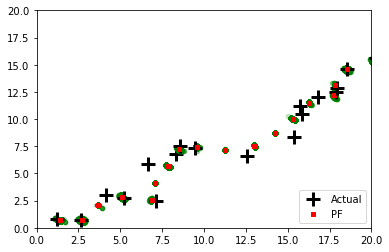

In [10]:
from numpy.random import seed
seed(2) 
run_pf22(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

# Constant acceleration case

In [11]:
"""initial particle distribution(uniform or Gaussian around init GPS)"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions with a consistent random offset
    positions = (np.arange(N) + random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [131]:
from scipy.stats import multivariate_normal

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    """weighting by iid mulvivariate Gaussian density
    with covs 0, is product of prob. of each dimensional variable"""
    N = len(particles)
    
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
        
    weights += 1.e-300
    tot_weights = sum(weights)
    weights /= sum(weights) # normalize
        
    return weights

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def predict_with_acc_try(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[:,0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[:,1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)

def predict_with_acc_mu(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)


def fobj(a, solution, particles, u, std, z, R, landmarks, dt=1.):
    N = len(particles)
    
    weights = np.ones(N) / N
    #predict_with_acc_try(a, particles, u=(0.00, 1.414), std=(.2, .05))
    predict_with_acc_try(a, particles, u=(0.00, 1.414), std=std)
    weights = update(particles, weights, z, R, landmarks)

    #return -1.*np.square(solution - weights)
    return np.square(solution - weights)

def estimate_a(a):
    """returns mean and variance of the weighted particles"""
    mean = np.average(a, axis=0)
    var  = np.average((a - mean)**2)
    return mean, var

# Constant acceleration case

In [132]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf361(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])
    
    npop = len(particles)
    sigma= 0.1
    lr= 0.1
    
    a = [0.0, np.random.randn()] 

    for x in range(iters):

        robot_pos += (1+randn(), 1+randn())
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [0.0, 0.22864179504556809] errors: 0.14823068355425198
params: [0.0, 0.22864179504556809] errors: 0.2684639905367078
params: [0.0, 0.22864179504556809] errors: 0.057055111712812454
params: [0.0, 0.22864179504556809] errors: 0.15278322049603138
params: [0.0, 0.22864179504556809] errors: 0.22405683302772766
params: [0.0, 0.22864179504556809] errors: 0.03629046921534986
params: [0.0, 0.22864179504556809] errors: 0.08697321178912126
params: [0.0, 0.22864179504556809] errors: 0.1641727608770936
params: [0.0, 0.22864179504556809] errors: 0.15010697648529628
params: [0.0, 0.22864179504556809] errors: 0.09064803201532314
params: [0.0, 0.22864179504556809] errors: 0.944408980497176
params: [0.0, 0.22864179504556809] errors: 0.714158556122968
params: [0.0, 0.22864179504556809] errors: 0.28458465863416665
params: [0.0, 0.22864179504556809] errors: 0.06146380379854548
params: [0.0, 0.22864179504556809] errors: 0.12022285687275387
params: [0.0, 0.22864179504556809] errors: 1.302873528903518

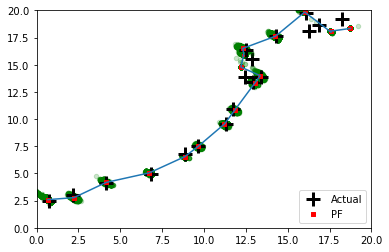

In [133]:
from numpy.random import seed
seed(2) 

run_pf361(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

# Adapting parameters
## update only mu of parameter search distribution

In [134]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf36(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])
    
    npop = len(particles)
    sigma= 0.1
    lr= 0.1

    #angular acc.=0, linear acc. = mu 0, sig 1
    a = [0.0, np.random.randn()] 

        
    for x in range(iters):

        # simple random walk
        robot_pos += (1+randn(), 1+randn())
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        
        # for evolutionary filters optimization, decide w s.t. likelihood to be maximized
        S = np.random.randn(npop, 2) 
        R = np.zeros(npop)

        # jitter w using gaussian of sigma 0.1
        a_try = a + sigma*S 
        
        # jitter w using gaussian of sigma 0.1
        R = fobj(a_try, weights, particles.copy(), u=(0.00, 1.414), std=(.4, .1), 
                    z=zs, R=sensor_std_err, landmarks=landmarks, dt=1.)
                
        # standardize the rewards to calc weight
        A = (R - np.mean(R)) / np.std(R)

        # perform the parameter update. The matrix multiply below
        a = a + lr/(npop*sigma) * np.dot(S.T, A)
        
        #predict with acc
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        
        #update
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        
        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [-0.0040828   0.20839543] errors: 0.07739730959588714
params: [-0.00047774  0.21291155] errors: 0.08945907414708414
params: [-0.0004079   0.20783183] errors: 0.025174836052746143
params: [-0.00061629  0.21942702] errors: 0.03562892824136323
params: [0.0128261  0.24361839] errors: 0.13716205706896728
params: [0.03326656 0.27084241] errors: 0.09858988097647665
params: [0.04238858 0.26405181] errors: 0.19924715622146613
params: [0.04209655 0.26426416] errors: 0.12355564132485192
params: [0.05668718 0.2730688 ] errors: 0.16183702874284592
params: [0.05962793 0.2993898 ] errors: 0.1005364903196582
params: [0.08612988 0.31246353] errors: 0.7932394858002321
params: [0.08032714 0.33002463] errors: 0.07543907248622507
params: [0.09311497 0.31622668] errors: 0.2127039755108616
params: [0.09147976 0.3052946 ] errors: 0.055401503294261835
params: [0.10051925 0.31089162] errors: 0.6983602646081023
params: [0.09208285 0.30154918] errors: 0.9618148178695897
params: [0.08032048 0.29610819] err

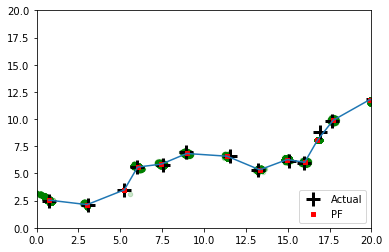

In [135]:
from numpy.random import seed
seed(2) 
#run_pf5(N=5000, plot_particles=True)
run_pf36(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

# update mu, cov of parameter search distribution
# all noise std = 1

In [144]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf36(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])
    
    npop = len(particles)
    #sigma= 0.1
    sigma = np.ones(2)
    lr= 0.001
    lr_cov = 0.001

    #angular acc.=0, linear acc. = mu 0, sig 1
    a = [0.0, np.random.randn()] 

        
    for x in range(iters):

        # simple random walk
        robot_pos += (1+randn(), 1+randn())
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        
        # for evolutionary filters optimization, decide w s.t. likelihood to be maximized
        S = np.random.randn(npop, 2) 
        R = np.zeros(npop)

        # jitter w using gaussian of sigma 1
        a_try = a + sigma*S 
        
        # jitter w using gaussian of sigma 1
        R = fobj(a_try, weights, particles.copy(), u=(0.00, 1.414), std=(.5, .5), 
                    z=zs, R=sensor_std_err, landmarks=landmarks, dt=1.)
                
        # standardize the rewards to calc weight
        A = (R - np.mean(R)) / np.std(R)

        # perform the parameter update. The matrix multiply below
        a = a + lr/(npop*sigma) * np.dot(S.T, A)
        sigma = sigma*np.exp(lr_cov/2 * np.dot((S * S -1).T, A))

        
        #predict with acc
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.5, .5))
        
        #update
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        
        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [-7.42553470e-08  2.28663609e-01] errors: 0.04672014674015783
params: [-4.86075022e-06  2.28678052e-01] errors: 0.0341432924175619
params: [2.13516466e-05 2.28710866e-01] errors: 0.09259023573493365
params: [6.39678663e-05 2.28733761e-01] errors: 0.043215767761864476
params: [6.02681616e-06 2.28751298e-01] errors: 0.12163892694283095
params: [3.44272995e-05 2.28778202e-01] errors: 0.07890709832324456
params: [2.78177010e-05 2.28805132e-01] errors: 0.10942892193314094
params: [2.06018215e-06 2.28839407e-01] errors: 0.12256838599371989
params: [5.42945621e-05 2.28842518e-01] errors: 0.21360033166361156
params: [1.03019213e-05 2.28826865e-01] errors: 0.08382950701456816
params: [3.23947623e-05 2.28843959e-01] errors: 0.7903870735895836
params: [4.74037278e-05 2.28867254e-01] errors: 0.07870105204514403
params: [2.34374165e-05 2.28910354e-01] errors: 0.2961718646325053
params: [-3.66852941e-06  2.28839577e-01] errors: 0.04175327521452167
params: [-1.78337940e-05  2.28862378e-01] er

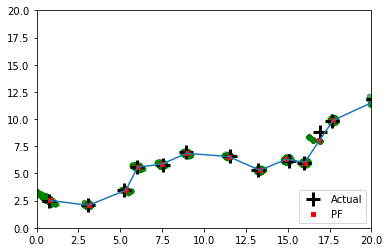

In [145]:
from numpy.random import seed
seed(2) 
#run_pf5(N=5000, plot_particles=True)
run_pf36(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))